# Modelling tides

This guide demonstrates how to use the [`model_tides` function from `eo_tides.model`](../../api/#eo_tides.model.model_tides). 
This function allows you to model tide heights at multiple coordinates and/or timestep, using using one or more ocean tide models.

The `model_tides` can be used independently of Earth observation (EO) data, e.g. for any application where you need to generate a time series of tide heights.
However, it also underpins the more complex EO-related functions demonstrated in [Combining tides with satellite data](../Satellite_data.ipynb).

## Getting started
As a first step, we need to tell `eo-tides` the location of our tide model directory (if you haven't set this up, [refer to the setup instructions here](../setup.md)).

We will pass this path to `eo-tides` functions using the `directory` parameter.

<!-- For local installation:
pip install -e ../../. -->

In [30]:
tide_model_dir = "../../tests/data/tide_models/"

We can use the [`eo_tides.model.list_models`](../../api/#eo_tides.model.list_models) function to verify that we have some tide model data available in this directory:

In [31]:
from eo_tides.model import list_models

list_models(directory=tide_model_dir, show_supported=False);

─────────────────────────────────────────────────────────────────────────────────────
 󠀠🌊  | Model                | Expected path                                                
─────────────────────────────────────────────────────────────────────────────────────
 ✅  │ EOT20                │ ../../tests/data/tide_models/EOT20/ocean_tides               
 ✅  │ HAMTIDE11            │ ../../tests/data/tide_models/hamtide                         
─────────────────────────────────────────────────────────────────────────────────────

Summary:
Available models: 2/50


<div class="alert alert-info">
    
**Note:** The directory above contains demo data only. 
Update the `directory` path to point to the location of your own tide model directory.

</div>

## Using model_tides

In the example below, we model hourly tides for Broome in Western Australia across January 2018:

In [32]:
from eo_tides.model import model_tides
import pandas as pd

tide_df = model_tides(
    x=122.2186,
    y=-18.0008,
    time=pd.date_range(start="2018-01-01", end="2018-01-31", freq="1h"),
    directory=tide_model_dir,
)

# Print outputs
tide_df.head()

Modelling tides using EOT20


,,,tide_model,tide_height
time,x,y,,
2018-01-01 00:00:00,122.2186,-18.0008,EOT20,1.229286
2018-01-01 01:00:00,122.2186,-18.0008,EOT20,2.162897
2018-01-01 02:00:00,122.2186,-18.0008,EOT20,2.476600
2018-01-01 03:00:00,122.2186,-18.0008,EOT20,2.112390
2018-01-01 04:00:00,122.2186,-18.0008,EOT20,1.181283


The resulting `pandas.DataFrame` contains:

* `time`, `x`, `y`: Our original input timesteps and coordinates
* `tide_model`: a column listing the tide model used
* `tide_height`: modelled tide heights representing tide height in metres relative to Mean Sea Level

We can plot our modelled outputs to view how tides changed across the month. 
Looking at the y-axis, we can see that tides at this macrotidal region ranged from -4 metres up to a maximum of +4 metres relative to Mean Sea Level:

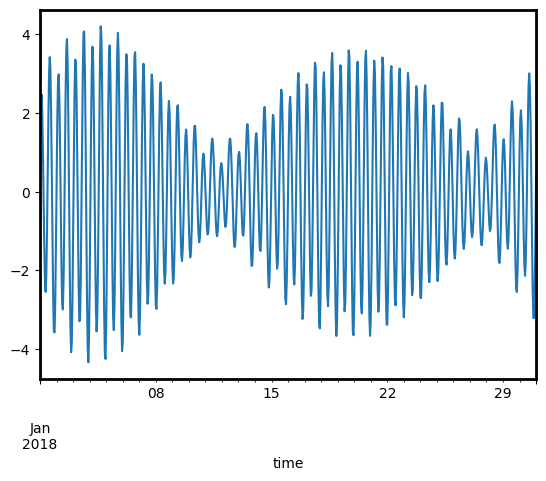

In [33]:
tide_df.reset_index(["x", "y"], drop=True).tide_height.plot();

### Multiple models

By default, `model_tides` will model tides using the EOT20 tide model. 
However, we can easily model tides using multiple models by passing a list of models to the `model` parameter.
`eo-tides` will process these in parallel where possible, and return the data into a single `pandas.DataFrame`.

For example, we can model tides using the EOT20 and HAMTIDE11 models.

<div class="alert alert-info">
    
**Note:** Here we also set `output_format="wide"`, which will place data from each model into a new column.
    This can make it easier to plot our data. For more details, [see below](#"Wide"-and-"long"-output-formats).

</div>

In [34]:
tide_df_multiple = model_tides(
    x=122.2186,
    y=-18.0008,
    model=["EOT20", "HAMTIDE11"],
    time=pd.date_range(start="2018-01-01", end="2018-01-20", freq="1h"),
    output_format="wide",
    directory=tide_model_dir,
)

# Print outputs
tide_df_multiple.head()

Modelling tides using EOT20, HAMTIDE11 in parallel


100%|██████████| 2/2 [00:00<00:00, 11.67it/s]


Converting to a wide format dataframe


,,tide_model,EOT20,HAMTIDE11
time,x,y,,
2018-01-01 00:00:00,122.2186,-18.0008,1.229286,1.422702
2018-01-01 01:00:00,122.2186,-18.0008,2.162897,2.302042
2018-01-01 02:00:00,122.2186,-18.0008,2.476600,2.537032
2018-01-01 03:00:00,122.2186,-18.0008,2.112390,2.072845
2018-01-01 04:00:00,122.2186,-18.0008,1.181283,1.034931


Plot our outputs to see both models on a graph:

<Axes: xlabel='time'>

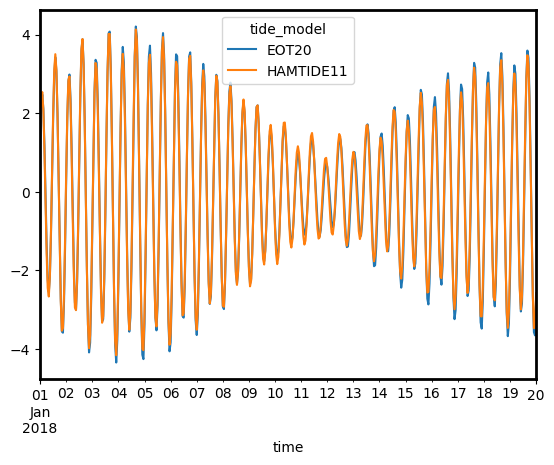

In [35]:
# Print outputs
tide_df_multiple.reset_index(["x", "y"], drop=True).plot(legend=True)

### "One-to-many" and "one-to-one" modes

By default, the `model_tides` function operates in **"one-to-many"** mode, which will model tides at every requested location, for every requested timestep.
This is particularly useful for satellite Earth observation applications where we may want to model tides for a large set of satellite pixels, for every satellite acquisition through time.

For example, if we provide two locations and two timesteps, the function will return four modelled tides:
```
2 locations * 2 timesteps = 4 modelled tides
```

In [36]:
model_tides(
    x=[122.21, 122.22],
    y=[-18.20, -18.21],
    time=pd.date_range(start="2018-01-01", end="2018-01-20", periods=2),
    mode="one-to-many",
    directory=tide_model_dir,
)

Modelling tides using EOT20 in parallel


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


,,,tide_model,tide_height
time,x,y,,
2018-01-01,122.21,-18.20,EOT20,1.231424
2018-01-20,122.21,-18.20,EOT20,-2.923815
2018-01-01,122.22,-18.21,EOT20,1.231424
2018-01-20,122.22,-18.21,EOT20,-2.923815


However, another common use case is having a list of locations you want to use to model tides for, each with a single timestep.
Using **"one-to-one"** mode, we can model tides for each pair of locations and times:
```
2 timesteps at 2 locations = 2 modelled tides
```

For example, you may have a `pandas.DataFrame` containing `x`, `y` and `time` values:

In [37]:
df = pd.DataFrame(
    {
        "time": pd.date_range(start="2018-01-01", end="2018-01-20", periods=2),
        "x": [122.21, 122.22],
        "y": [-18.20, -18.21],
    }
)
df

,time,x,y
0,2018-01-01,122.21,-18.20
1,2018-01-20,122.22,-18.21


We can pass these values to `model_tides` directly, and run the function in "one-to-one" mode to return a tide height for each row:

In [38]:
# Model tides and add back into dataframe
df["tide_height"] = model_tides(
    x=df.x,
    y=df.y,
    time=df.time,
    mode="one-to-one",
    directory=tide_model_dir,
).tide_height.values

# Print dataframe with added tide height data:
df.head()

Modelling tides using EOT20 in parallel


100%|██████████| 2/2 [00:00<00:00, 13.61it/s]


,time,x,y,tide_height
0,2018-01-01,122.21,-18.20,1.231424
1,2018-01-20,122.22,-18.21,-2.923815


### "Wide" and "long" output formats
By default, modelled tides will be returned in **"long"** format, with multiple models stacked under a `tide_models` column and tide heights in the `tide_height` column:


In [39]:
model_tides(
    x=[122.21, 122.22],
    y=[-18.20, -18.21],
    time=pd.date_range(start="2018-01-01", end="2018-01-20", periods=2),
    model=["EOT20", "HAMTIDE11"],
    output_format="long",
    directory=tide_model_dir,
)

Modelling tides using EOT20, HAMTIDE11 in parallel


100%|██████████| 4/4 [00:00<00:00, 15.01it/s]


,,,tide_model,tide_height
time,x,y,,
2018-01-01,122.21,-18.20,EOT20,1.231424
2018-01-20,122.21,-18.20,EOT20,-2.923815
2018-01-01,122.22,-18.21,EOT20,1.231424
2018-01-20,122.22,-18.21,EOT20,-2.923815
2018-01-01,122.21,-18.20,HAMTIDE11,1.435844
2018-01-20,122.21,-18.20,HAMTIDE11,-2.662284
2018-01-01,122.22,-18.21,HAMTIDE11,1.435844
2018-01-20,122.22,-18.21,HAMTIDE11,-2.662284


We can also run the function in **"wide"** format, which will return a new column for each tide model (e.g. `EOT20`, `HAMTIDE11` etc):

In [40]:
model_tides(
    x=[122.21, 122.22],
    y=[-18.20, -18.21],
    time=pd.date_range(start="2018-01-01", end="2018-01-20", periods=2),
    model=["EOT20", "HAMTIDE11"],
    output_format="wide",
    directory=tide_model_dir,
)

Modelling tides using EOT20, HAMTIDE11 in parallel


100%|██████████| 4/4 [00:00<00:00, 17.02it/s]


Converting to a wide format dataframe


tide_model                   EOT20  HAMTIDE11
time       x      y                          
2018-01-01 122.21 -18.20  1.231424   1.435844
           122.22 -18.21  1.231424   1.435844
2018-01-20 122.21 -18.20 -2.923815  -2.662284
           122.22 -18.21 -2.923815  -2.662284

## Next steps

Now that we have demonstrated how to model tides, we can learn how to [combine modelled tides with satellite data](../Satellite_data) for further analysis.